In [35]:
import numpy as np
from matplotlib import pyplot as plt


In [36]:
### define wanninkhof (1992) formulation
def wanninkhof92(u, Sc):
    # u is in m s^-1
    # Sc is dimensionless
    # k is in cm hr^-1
    k = 0.31*u**2.0*(Sc/600.0)**0.5
    return k

### define schmidt number
def schmidtCO2(T):
    # T must be in celsius
    # coefs are for CO2
    A = 2073.1
    B = 125.62
    C = 3.6276
    D = 0.043219
    sc = A- B*T + C*T**2 -D*T**3
    return sc

def solubility(TEMP):
    tk = TEMP + 273.15 # convert to Kelvin
    tk100 = tk * 1e-2
    tk1002 = tk100 * tk100
    s = 35.0 # psu
    ff = np.exp(-162.8301 + (218.2968/tk100) + 90.9241*np.log(tk100) - 1.47696*tk1002 + s*(0.025695 - 0.025225*tk100 + 0.0049867*tk1002))
    return ff # units are mol/kg/atm

In [235]:
c = 0.0423 # K^-1
S0 = 340.0 # W m^-2
sigma = 5.67e-8 # W m^-2 K^-4
Btil = c*(2.0*S/sigma)**0.25 # dimensionless 
Pa = 284.0e-6 #atm
u = 10.0 # m/s
T0 = 10.0 # C
alpha_0 = 0.3 # dimensionless
k = wanninkhof92(u, schmidtCO2(T0)) * 0.01/3600.0 # cm hr^-1 -> m s^-1
ff = solubility(T0) # mol/kg/atm
rho = 1050.0 # kg m^-3 
Ctil = k * ff * Pa * rho * np.exp(-Btil * (1.0-alpha_0)**0.25) # m s^-1 mol kg^-1 atm^-1 atm kg m^-3 
#-> s^-1 mol  m^-2 

In [236]:
alpha = np.linspace(0.0, 1.0, 100)
phi1 = Ctil * np.exp(-Btil * (1.0-alpha)**0.25) - k * ff * Pa
def phiA(alpha, alpha_0):
    phi = k * ff * Pa * rho * (np.exp(c*((2.0*S/sigma)**0.25)*((1.0-alpha)**0.25) - (1.0-alpha_0)**0.25)-1.0)
    return phi
dphi_dalpha = Ctil *np.exp(-Btil * (1.0-alpha)**0.25) * Btil * 0.25 * (1.0-alpha)**0.25 # 


/Users/matthewgentry/anaconda3/envs/myculabenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/matthewgentry/anaconda3/envs/myculabenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


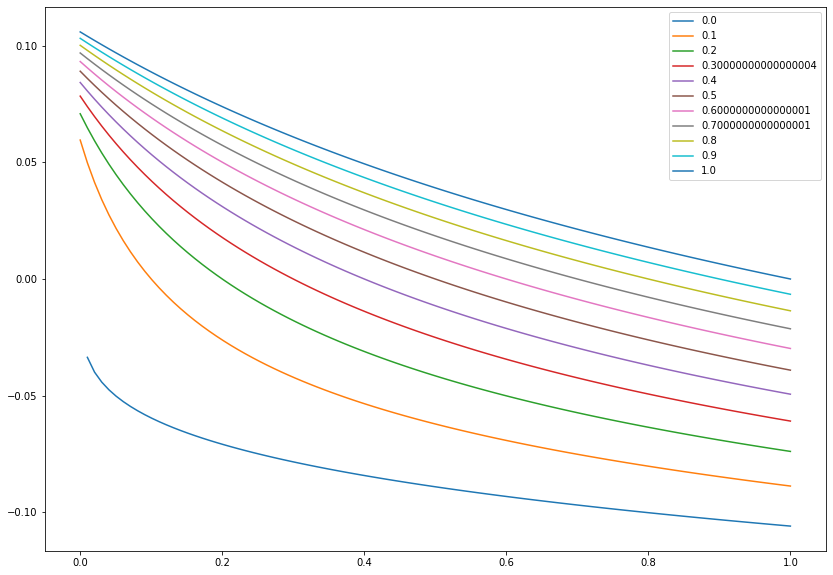

In [237]:
plt.figure(figsize=(14, 10))
for alpha_0 in np.linspace(0.0, 1, 11):
    dpda = k * ff * c / Pa *(2.0*S/sigma)**0.25 * -0.25 * ((alpha_0+alpha)/2.0)**-0.75
    da = alpha - alpha_0
    plt.plot(alpha, dpda*da, label=alpha_0)
plt.legend()


/Users/matthewgentry/anaconda3/envs/myculabenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


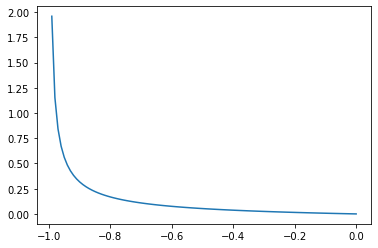

In [238]:
# linearized dphi/dalpha
dpda = k * ff * c / Pa *(2.0*S/sigma)**0.25 * -0.25 * alpha**-0.75
da = alpha - alpha_0
plt.plot(da, dpda*da)

### Let's build a numerical model now that I can run
Start with the one-layer RT model
We will solve this semi-explicitly by explicitly forward-calculating the surface and atmospheric temperatures, and then solving for them again using the new values for each temperature in the solve for the other temperature.


In [239]:
import numpy as np
from matplotlib import pyplot as plt
steph_boltz = 5.67e-8
rho_water = 1.22e3 # kg/m^3
A_ocn = 1.0 #0.7* np.pi * 6e7**2.0 ## approximate ocean area
V_ocn = 3e3 * A_ocn
V_top = 100.0 * A_ocn
V_deep = V_ocn - V_top
e_o = 1.0 # emissivity of the ocn
e_a = 0.7 # emissivity of the atm
ma = 1.0* 1.0* 10e3 # mass of atmosphere in kg
mo = V_top * rho_water
ca = 1000.0 # K/kg
co = 4218.0 # K/kg
dt = 0.01 # years
s_per_yr = 3600.0*24.0*365.0 #s/yr
alpha = 0.3

def TA2(TA, TO):
    emission_ocn = e_o * steph_boltz * TO**4.0 * s_per_yr
    emission_atm = e_a * steph_boltz * TA**4.0 * s_per_yr
    numer = e_a*emission_ocn - 2.0 * emission_atm
    denom = ma * ca
    return numer/denom * dt + TA

def TO2(TA, TO):
    emission_ocn = e_o * steph_boltz * TO**4.0 * s_per_yr
    emission_atm = e_a * steph_boltz * TA**4.0 * s_per_yr
    solar = S*(1.0 - alpha) * s_per_yr
    numer = solar - emission_ocn + emission_atm
    denom = mo*co
    return numer/denom * dt + TO


In [255]:
times = np.arange(0, 100, dt)
N = len(times)
print(N)
TA_array = np.zeros(N)
TO_array = np.zeros(N)
e_a = 0.7

TA_array[0] = 240.0 
TO_array[0] = 285.0
for t in range(N-1):
    S = S0 #+10.0*np.sin(times[t]*2.0*np.pi/11.0)
    e_a += 2e-5
    TA_array[t+1] = TA2(TA_array[t], TO_array[t])
    TO_array[t+1] = TO2(TA_array[t], TO_array[t])


10000


(230, 310)

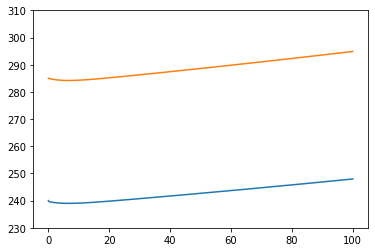

In [256]:
plt.plot(times, TA_array)
plt.plot(times, TO_array)
plt.ylim(230, 310)

In [253]:
TA_array[-1], TO_array[-1]

(249.7813859810651, 297.04845640928187)